# Raster Data

This notebook is a modified version of M. Janosov's original, as presented in *[Geospatial Data Science Essentials](https://www.janosov.com/books/geo/)*


Earlier, we mentioned that there are two main types of data formats used in geospatial analytics: vector data and raster data. While we have been extensively studying vector data so far, it is now time to learn about raster data.

Raster data is a core component of geospatial analysis, consisting of a grid of pixels where each pixel holds one or more data points or bands, representing information such as population density, land cover, or elevation. In the case of multi-band data, each band in a pixel can store different types of data, such as spectral information from various wavelengths in remote sensing. This type of data is typically stored in file formats such as PNG or GeoTIFF and can come in multiple resolutions, each offering different levels of detail and types of data layers. Efficient handling and processing of raster data are crucial for applications in remote sensing, environmental modeling, and many more.


In this notebook, we will explore techniques and tools in Python to handle large raster datasets. 
- We will start by demonstrating how to read and write raster data, followed by methods to clip rasters to focus on specific regions.
- We recap the topic of map projections and explore a few visualization techniques.
- We will learn about more advanced analytical operations as well, such as computing zonal statistics, converting raster grids into vector data, and downsampling large raster files.

### 1.Global Population Raster Data


Throughout this notebook, we will rely on various versions of the [GHSL - Global Human Settlement Layer](https://human-settlement.emergency.copernicus.eu/download.php?ds=pop) raster database, which contains global population estimates in raster data format. Note that this file is 5.4GB (in zipped form) and 9GB when decompressed. It is possible to select individual regions and download smaller files for each one.

This dataset is freely available and was created by the European Union's Copernicus Team at the Joint Research Center. According to their website, their aim in creating this data set was to create new global spatial information and publicly available knowledge describing human presence on Earth. This dataset operates under a fully open and free data license policy. We can further study the detailed technical documentation [here](https://human-settlement.emergency.copernicus.eu/documents/GHSL_Data_Package_2023.pdf?t=1698413418). 

For the following explorative sections, we may download any raster file we wish from their website, where we can select a prepared transformed version of the GHSL data set from a variety of temporal epochs, two coordinate systems, and a handful of spatial resolutions. For instance, from the GHS-POP product, we can select the epoch of 2030 (future projection) with a resolution of 100m in the Mollweide coordinate system.



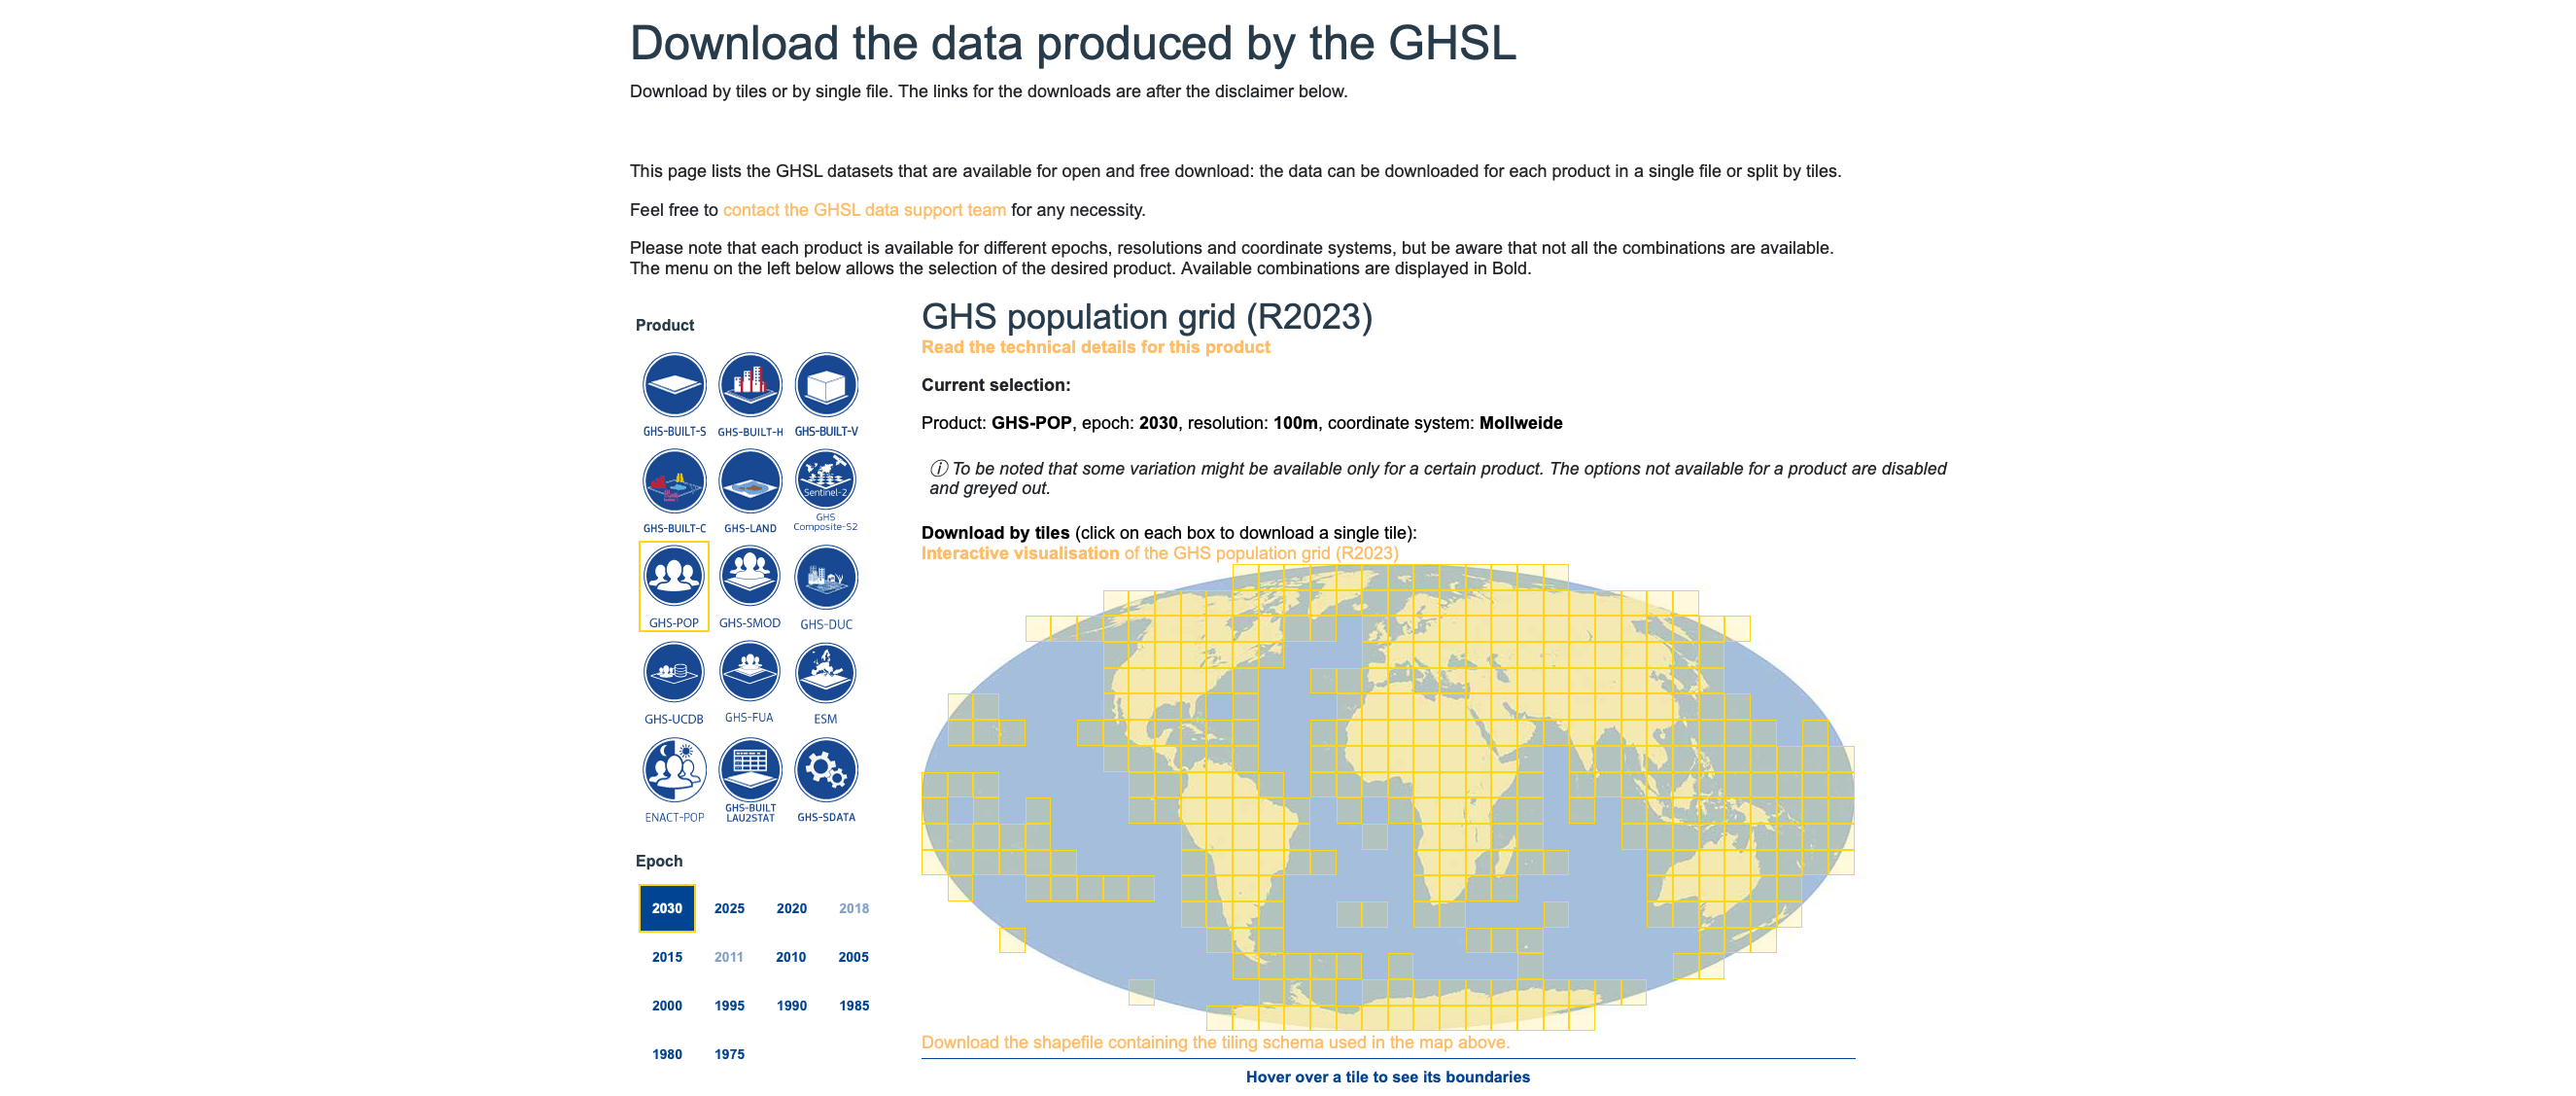


### 2. Reading Raster Data

Raster data is a fundamental type of geospatial data used in various applications, including remote sensing and environmental modeling. In this section, we will learn how to read raster data using Python. As an example, we will use the Global Human Settlement Layer (GHSL) data for the year 2030, using the WGS84 coordinate reference system (CRS) and a resolution of 30 arcseconds, stored in a GeoTIFF format. We note that the resolution is defined in grid cells with a size of 30 arcseconds, referring to the fact that the WGS84 (EPSG:4326) coordinate system stores locational information in longitude and latitude angles.

In the example below, first, we import the [rasterio](https://rasterio.readthedocs.io/en/stable/) library, which is the most common package for handling raster data in Python. Then, we define the path to the raster file based on the downloaded file's name and location. Using `rasterio.open()`, we open this file and read the data using the `read()` method. Here, we can specify which band we would like to read - which, in the case of the population data, is not optional as we only have one band containing the population data. However, for instance, in the case of satellite images, the input data usually provides multiple bands, such as red, green, and blue channels. 

Then, we also extract additional information, such as the raster profile, bounds, resolution, and statistical values (mean, minimum, and maximum) from the raster data. The profile contains metadata about the raster file, such as the data type, number of bands, and CRS, which we print out for further observation.

**NOTE**

1. The following cell should NOT be executed unless one has a well-equipped workstation, with a very large quantity of memory available.
2. The reduced, clipped raster file is available here: [clipped](https://www.dropbox.com/scl/fi/cmfxrxh2vjebrfmh8zbu3/clipped_raster_europe.tif?rlkey=vx2uu7gqyo6gc19yucl2dtwrw&dl=0)
3. Once this file is downloaded, you can proceed directly to Section 5, after just looking at the code in Sections 3 and 4 to see how it was generated.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Import rasterio
import rasterio

# Define the raster file path (modify if necessary)
folder = 'GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0' 
file_name = 'GHS_POP_E2030_GLOBE_R2023A_54009_100_V1_0.tif'
#folder = 'GHS_POP_E2030_GLOBE_R2023A_4326_30ss_V1_0' 
#file_name = 'GHS_POP_E2030_GLOBE_R2023A_4326_30ss_V1_0.tif'
raster_file = folder + '/' + file_name

# Read the raster file
with rasterio.open(raster_file) as src:
    # Read the raster data
    raster_data = src.read(1)
    
    # Read additional information
    profile = src.profile
    bounds = src.bounds
    resolution = src.res
    mean_val = raster_data.mean()
    min_val = raster_data.min()
    max_val = raster_data.max()

# Print the extracted information
print("Profile:", profile)
print("Bounds:", bounds)
print("Resolution:", resolution)
print("Mean value:", mean_val)
print("Minimum value:", min_val)
print("Maximum value:", max_val)

Reading and analyzing raster data is a fundamental step in geospatial analysis. In this example, we used the GHSL data to read and extract population estimates for the year 2030 in WGS84 CRS. 

As the code block's output shows, this raster data, data stored in a GeoTIFF format, has a data type of float64. It has a width of 43,202 pixels and a height of 21,384 pixels, containing a single band of data. The file is tiled with block sizes of 256x256 pixels and compressed using LZW compression.

The spatial extent of the data covers the entire globe, with bounds ranging from -180.0079 to 180.0087 degrees in longitude and -89.1004 to 89.0996 degrees in latitude. The resolution of each pixel is approximately 0.0083 degrees. The mean population value within the raster is approximately 9.25, with a minimum value of 0 and a maximum value of 394,367.26, indicating significant variability in population density across the globe. Here, we also note that the population values, indicating the headcount of inhabitants, are modeled values and come from a series of data processing steps, from data integration and enhancement to interpolation. Hence, the maximum (and all other) values stored within the grid are float, not integer, as we would expect.

### 3. Clip the Raster Data File Using GeoPandas

Clipping a raster data file to a specific region of interest is a common task in geospatial analysis. This process allows us to focus on a particular area, reducing the dataset size and improving processing efficiency. 


In this section, we will demonstrate how to clip the GHSL raster data file using GeoPandas and Rasterio's `mask` function. By using this tool, we will narrow down the global population raster map to a subset that only focuses on Europe. We will first read the raster file, as demonstrated in the previous section. Then, we will use a `box` function from Shapely to capture the box that covers most of Europe. Finally, we use this Shapely object to clip the raster. As the outputted `profile` attribute of the raster file shows, the metadata of the clipped raster is updated accordingly to reflect the new dimensions of the smaller, clipped raster data set.

**NOTE**

The following cell use the results of the previous one.

In [ ]:
# Import all the libraries we use
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd

# Define the bounding box for Europe
bbox = box(-10.0, 34.0, 40.0, 72.0)
gdf = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs='EPSG:4326')

# Open the raster file
with rasterio.open(raster_file) as src:
    # Clip the raster using the bounding box
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Print the profile of the clipped raster
print("Profile of the clipped raster:")
for key, value in out_meta.items():
    print(f"{key}: {value}")

The output shows that the clipped raster file, similar to the original, is saved in GeoTIFF format with a pixel data type of `float64`. However, the raster dimensions are 6,001 pixels in width and 4,561 pixels in height, indicating the reduced area of the clipped region while retaining a single band and the original WGS84 coordinate reference system.

On the output, we see another concept that we should lay out and learn for raster data analysis - it is the `transform` attribute. In geospatial data, a transform is a mathematical function that converts pixel coordinates in a raster dataset to spatial coordinates, allowing each pixel to map to a specific location on Earth's surface. In `rasterio`, the transform is represented as a so-called [affine transformation matrix](https://en.wikipedia.org/wiki/Affine_transformation), which includes translation, scaling, rotation, and shearing. The matrix `| 0.01, 0.00, -10.01 | | 0.00, -0.01, 72.01 | | 0.00, 0.00, 1.00 |` indicates that each pixel is 0.01 map units wide and tall (with the y-coordinate increasing downward), the x-coordinate of the top-left pixel is -10.01, and the y-coordinate is 72.01. This matrix helps convert the raster's pixel coordinates to geographic coordinates, ensuring accurate spatial representation. While the theoretical parts can be tricky, in rasterio, we have, we have everything at hand to use this transform to efficiently convert between pixel and spatial coordinates with ease.

### 4. Writing Raster Data

Once we have clipped our raster data to a region of interest, the next step is often to save this modified data to a new file for further use or analysis. Writing raster data involves specifying the output file path and using Rasterio to write the clipped raster data for a new file while preserving its metadata.

In the example below, first, we read and clip the original raster file to the bounding box of Europe. Then, we  demonstrate how to write the clipped raster data into a new GeoTIFF file. This involves defining the output file path and using the `open` function from Rasterio in write mode to save the raster data.

**NOTE**

The clipped raster file is provided in the repository, and does not need to be generated please proceed to Section 5.


In [ ]:
# Import all the libraries we use
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd

# Define the bounding box for Europe
bbox = box(-10.0, 34.0, 40.0, 72.0)
gdf = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs='EPSG:4326')

# Open the raster file
with rasterio.open(raster_file) as src:
    # Clip the raster using the bounding box
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Define the output file path
clipped_raster_file = 'clipped_raster_europe.tif'

# Save the clipped raster
with rasterio.open(clipped_raster_file, 'w', **out_meta) as dest:
    dest.write(out_image)

print(f"Clipped raster saved to {clipped_raster_file}")

### 5. Visualizing Raster Data

Visualizing raster data is an important step in geospatial analysis as it helps to understand the distribution and patterns within the data. In this code example, we first import the necessary libraries including `rasterio`,  `show` from `rasterio.plot`, and `matplotlib.pyplot`. We then open the clipped raster file using `rasterio.open` and read the data with `src.read(1)`. The `show` function from Rasterio is used to visualize the raster data with a specified color map (`pink`), and `matplotlib.pyplot` is used to set the title of the plot. Additionally, we create a histogram of the raster data values using `plt.hist` to observe the pixel-level population value distribution and interpret the visualized raster map.


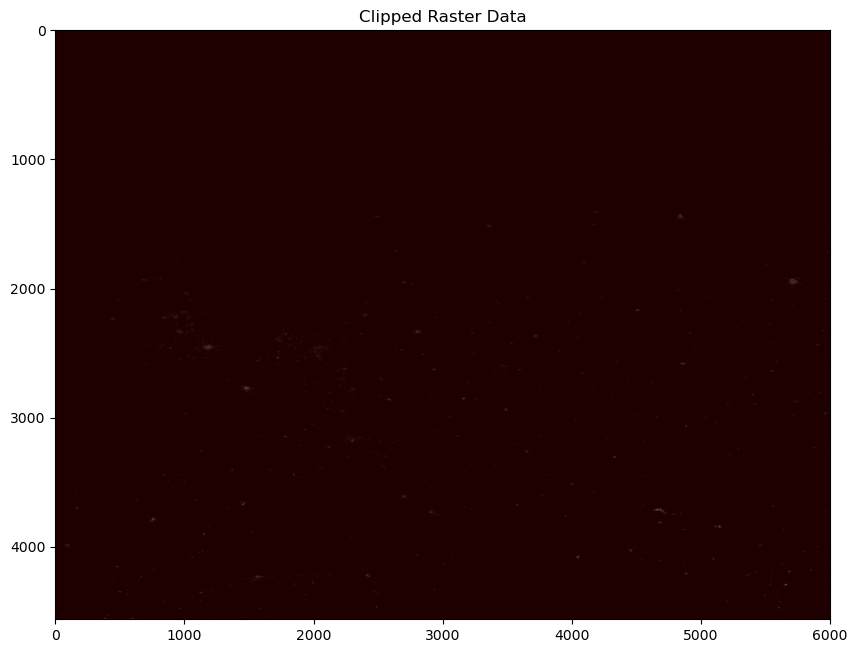

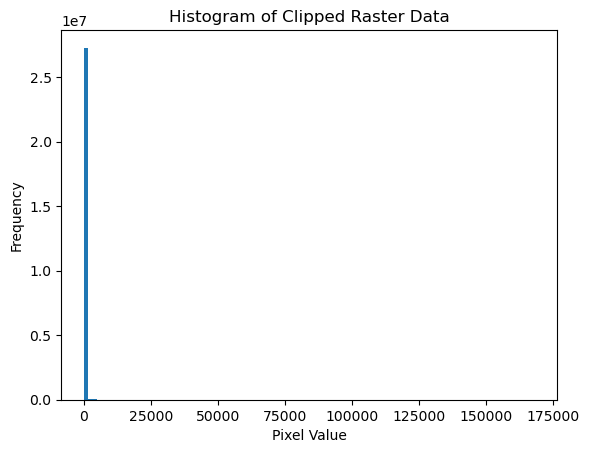

In [1]:
# Import necessary libraries
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt

# Define the output file path
clipped_raster_file = 'clipped_raster_europe.tif'

# Open the clipped raster file
with rasterio.open(clipped_raster_file) as src:
    out_image = src.read(1)
    out_meta = src.meta.copy()

# Visualize the clipped raster
fig, ax = plt.subplots(figsize=(10, 10))
show(out_image, ax=ax, cmap='pink')
ax.set_title('Clipped Raster Data')
plt.show()

# Visualize the histogram of the raster data
plt.hist(out_image.reshape(-1), bins=100)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Clipped Raster Data')
plt.show()

While all the visualization parameters seem to be properly set, we still only see a mostly black canvas, where we were expecting to see a population map of Europe instead. The reason behind this lies in the histogram, as there are just a few outlier values with extremely large population levels, which distort the coloring of the raster map so much that nothing will be visible. However, we can quickly overcome this issue and get a better view of Europe's population landscape by plotting the histogram with the y-scale set to logarithmic with `plt.yscale('log')`, and then apply this to the 2D raster map as well.

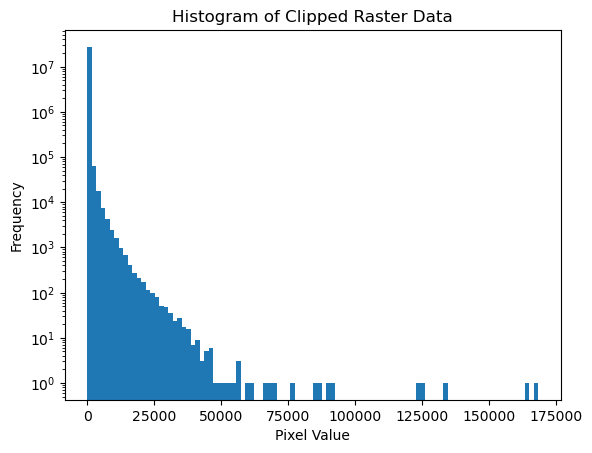

In [2]:
# Visualize the histogram of the raster data
plt.hist(out_image.reshape(-1), bins=100)
plt.yscale('log')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Clipped Raster Data')
plt.show()

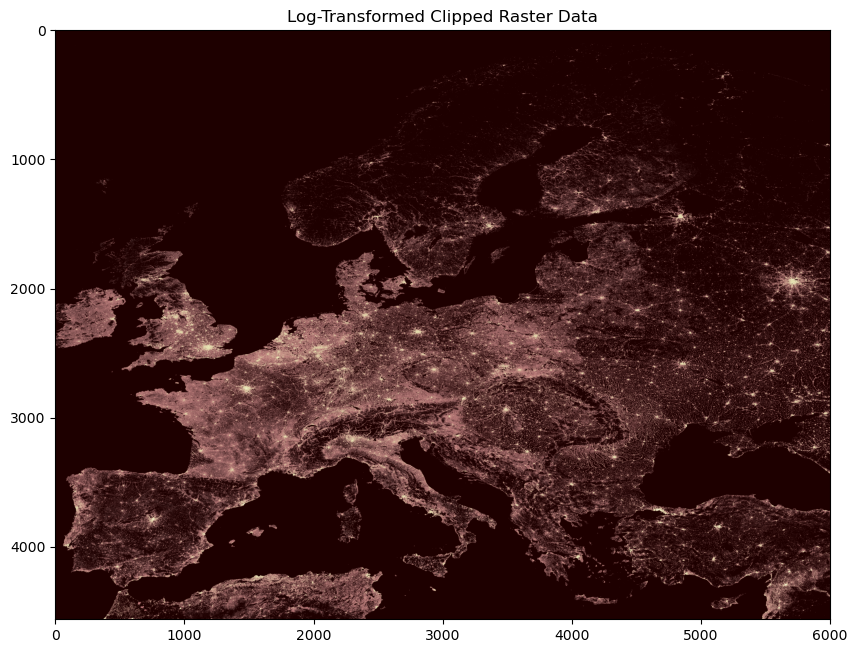

In [3]:
# Impport numpy
import numpy as np

# Apply a logarithmic transformation to the data
log_image = np.log1p(out_image)

# Visualize the transformed raster
fig, ax = plt.subplots(figsize=(10, 10))
show(log_image, ax=ax, cmap='pink')
ax.set_title('Log-Transformed Clipped Raster Data')
plt.show()

After doing the logarithmic scaling, we already have a familiar image - Europe with all the populated areas highlighted.

### 6. Histogram Equalization on Raster Data

Logarithmic scaling is a good basic solution for visualizing skewed raster data, as it helps to stretch out the low values and compress the high values, making the data distribution more visible. 

However, depending on the input data, *histogram equalization* can be a more effective method for enhancing the contrast in the data. Histogram equalization works by redistributing the pixel values so that they span the entire range of possible values more evenly. This is achieved by calculating the cumulative distribution function (CDF) of the pixel values and then using this CDF to remap the original pixel values. As a result of this process, pixel values that are more frequent in the original image will be spread out over a larger range in the equalized image, enhancing the contrast. The result, usually, is an improved overall contrast of the image. 

Let's see it with the previously clipped European population raster grid!


In [4]:
# Import necessary libraries
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import QuantileTransformer

# Define the output file path
clipped_raster_file = 'clipped_raster_europe.tif'

# Open the clipped raster file
with rasterio.open(clipped_raster_file) as src:
    out_image = src.read(1)
    out_transform = src.transform
    out_meta = src.meta.copy()

In [5]:
# Apply histogram equalization for better contrast
def histogram_equalization(image):
    # Flatten the image array and calculate the histogram
    image_flat = image.flatten()
    histogram, bin_edges = np.histogram(image_flat, bins=256, density=True)
    
    # Cumulative distribution function
    cdf = histogram.cumsum()
    cdf_normalized = cdf * (histogram.max() / cdf.max())
    
    # Use linear interpolation of the cdf to find new pixel values
    image_equalized = np.interp(image_flat, bin_edges[:-1], cdf_normalized)
    
    return image_equalized.reshape(image.shape)

# Apply the equalization
equalized_data = histogram_equalization(out_image)

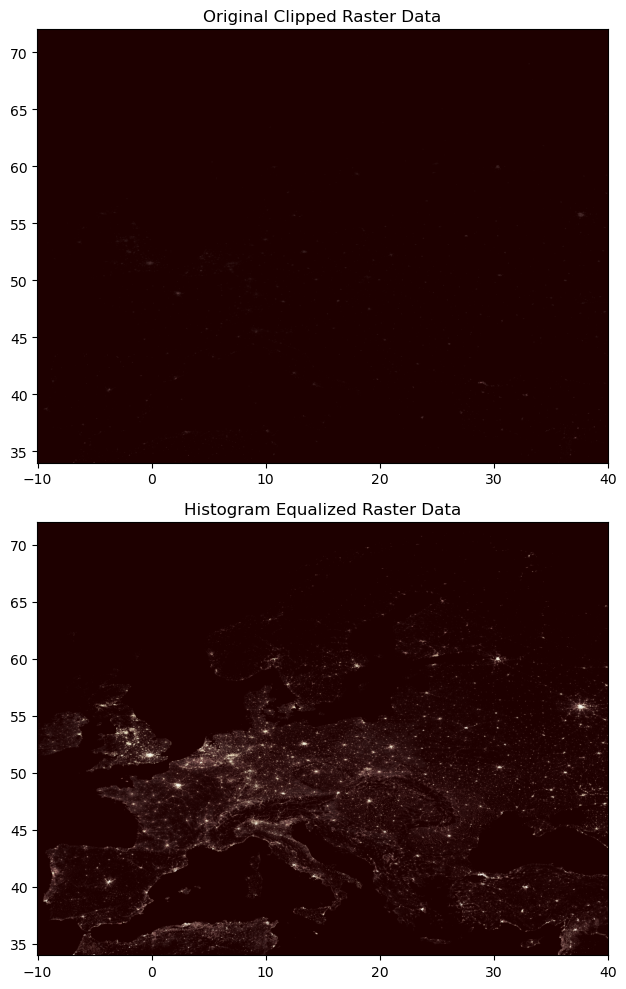

In [6]:
# Visualize the clipped and equalized raster
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Original visualization
show(out_image, transform=out_transform, ax=ax[0], cmap='pink')
ax[0].set_title('Original Clipped Raster Data')

# Enhanced visualization with histogram equalization
show(equalized_data, transform=out_transform, ax=ax[1], cmap='pink')
ax[1].set_title('Histogram Equalized Raster Data')

# Final touches on the plot
plt.tight_layout()
plt.show()

While in this section, we used a more advanced histogram equalization technique to visualize the widely spread population data; it is hard to tell whether this method or the much simpler logarithmic scaling method provided a better solution in the GHSL data. Nevertheless, depending on the input data, using one or the other method may provide significantly better results, so they are both handy tools in the geospatial data analysis stack.

### 7. Applying Simple Functions on Raster Data

In this section, we will explore how to apply simple functions to raster data. As an example, we will define a set of reclassification rules to categorize the data into different classes based on specific thresholds. Such operations are fundamental in geospatial analysis and can help transform raw data into more meaningful insights.

In the code below, we start by opening the clipped raster file and reading its data using the `rasterio` library. Then, we write a simple function called `reclassify`, which contains reclassification rules to categorize the continuous population data values into three classes: low, medium, and high population. Finally, we use the `numpy.vectorize` function to apply these rules to the entire raster dataset and visualize the results.

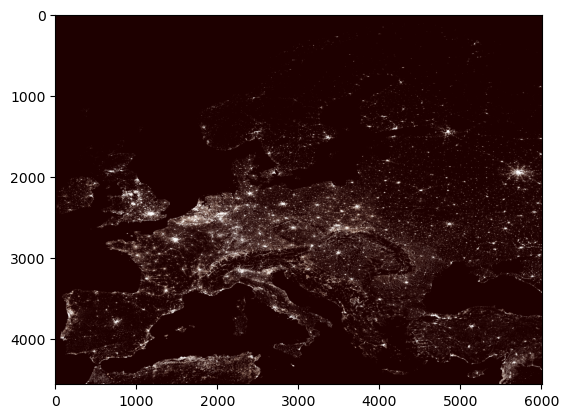

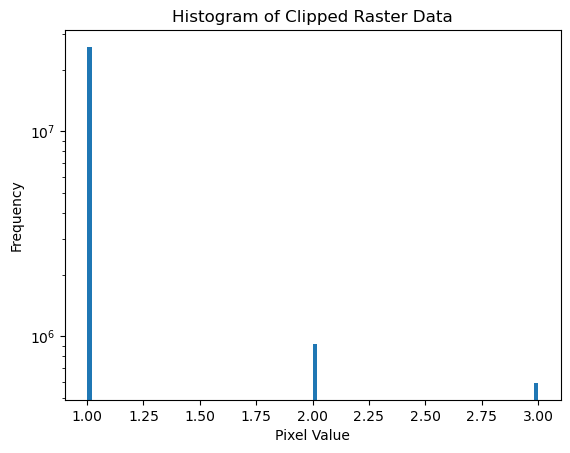

In [4]:
# Import necessary libraries
import rasterio
import numpy as np
from rasterio.plot import show

# Define the output file path
clipped_raster_file = 'clipped_raster_europe.tif'

# Open the raster file
with rasterio.open(clipped_raster_file) as src:
    raster_data = src.read(1)
    profile = src.profile

# Define reclassification rules
def reclassify(value):
    if value < 50:
        return 1  # Low population density
    elif value < 200:
        return 2  # Medium population density
    else:
        return 3  # High population density

# Apply reclassification
reclassified = np.vectorize(reclassify)(raster_data)

# Visualize the reclassified raster
show(reclassified, cmap='pink')

# Visualize the histogram of the reclassified raster data
plt.hist(reclassified.reshape(-1), bins=100)
plt.yscale('log')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Clipped Raster Data')
plt.show()

In this section, we demonstrated how to apply simple functions to raster data using `rasterio` and `numpy` to transform the original population raster grid into a categorical map differentiating low, medium, and high population levels. Then, we visualized this categorical raster map and plotted the histogram of its values to show the frequencies of the three categories.

### 8. Reprojecting Raster Data

We have already explored the topic of reprojecting geospatial vector data, and now we will extend this to raster data. As a reminder, geospatial data comes in different coordinate reference systems (CRS), which encode mathematical rules to map the three-dimensional earth to the two-dimensional plane. Different CRSs serve different purposes, while converting between them - reprojecting the data - is essential when combining datasets with different CRSs or when aligning data to specific tasks.

In this section, we will demonstrate how to reproject a raster file using the `rasterio` library in Python. We will again start by opening the clipped Europe population raster file and reading its data. Then, we will define the target CRS (in this case, EPSG:3857 or Web Mercator) and calculate the transform (remember, the raster - spatial transformation matrix) and dimensions for the output raster. Using the `calculate_default_transform` and `reproject` functions from `rasterio.warp`, we will transform the raster data to the target CRS, save the reprojected raster to a new file, and print the results to validate our process.

In [8]:
# Import necessary libraries
import rasterio
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling

# Path to your input raster file
raster_file = 'clipped_raster_europe.tif'

# Define the target CRS (EPSG:3857 for Web Mercator)
target_crs = 'EPSG:3857'

# Open the raster file
with rasterio.open(raster_file) as src:
    # Read the raster data
    raster_data = src.read(1)
    original_transform = src.transform
    original_crs = src.crs
    
    # Calculate the transform and dimensions of the output raster
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds)
    
    # Update the profile for the output raster
    profile = src.profile
    profile.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    # Reproject the raster data
    reprojected_raster = np.empty((height, width), dtype=src.dtypes[0])
    reproject(
        source=raster_data,
        destination=reprojected_raster,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=target_crs,
        resampling=Resampling.nearest)

print(f"Reprojected raster transformation completed.")

# Compare their CRS of the original and the reprojected raster data
print(f"Original CRS: {original_crs}")
print(f"Original Transform: {original_transform}")

print(f"New CRS: {profile['crs']}")
print(f"New Transform: {transform}")

Reprojected raster transformation completed.
Original CRS: EPSG:4326
Original Transform: | 0.01, 0.00,-10.01|
| 0.00,-0.01, 72.01|
| 0.00, 0.00, 1.00|
New CRS: EPSG:3857
New Transform: | 1263.50, 0.00,-1114076.18|
| 0.00,-1263.50, 11756037.07|
| 0.00, 0.00, 1.00|


As the output says, the reprojection of the raster data was successfully completed. The original raster used the EPSG:4326 CRS with coordinates in degrees, and its transform indicated a pixel size of 0.01 degrees. The new raster uses the EPSG:3857 CRS, commonly known as Web Mercator, with coordinates in meters. The new transform shows a pixel size of approximately 1263.50 meters. This reprojection technique allows us to adjust any raster data file to the desired CRS, aligning the data structure to both the use case and every other data set we are analyzing.

### 9. Compute Zonal Statistics

Zonal statistics is a geospatial analysis technique used to derive statistical measures of raster data within defined vector zones. By computing zonal statistics, we can summarize raster data, such as population density, elevation, or land cover, over specific areas, such as countries or administrative regions. This technique helps to extract meaningful insights and patterns from complex geospatial datasets.

In this section, we will calculate the total population for each country in Europe using the GHSL population raster dataset and a `GeoDataFrame` containing the geometries of European countries. We will achieve this by masking the raster data with each country's geometry and then summing the population values within each mask. 

Steps:
- read the `GeoDataFrame` of global countries,
- clip it to the area of interest,
- reproject it to match the raster's coordinate reference system (CRS), and
- perform zonal statistics using `Rasterio` and `GeoPandas`.

The resulting population totals are then added to the country-level `GeoDataFrame` and visualized using `Matplotlib`.


In [5]:
# Import necessary libraries
import geopandas as gpd
from shapely.geometry import box
import rasterio
import numpy as np
from rasterio.mask import mask
import matplotlib.pyplot as plt

# Read the natural earth low resolution dataset
#gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Load the sample dataset of world countries
file_name = 'naturalearth_lowres/naturalearth_lowres.shp'
gdf_countries = gpd.read_file(file_name)

# Create a bounding box for Europe
bbox = box(minx=-10, miny=34, maxx=40, maxy=72)
bbox = gpd.GeoDataFrame([bbox], columns=['geometry'])

# Clip the GeoDataFrame to Europe and exclude Russia
gdf_europe = gdf_countries[gdf_countries.continent == 'Europe']
gdf_europe = gpd.overlay(gdf_europe, bbox)
gdf_europe = gdf_europe[gdf_europe.name != 'Russia']

/var/folders/kx/_1g1vzv51nq1yv81c377flsr0000gn/T/ipykernel_65341/3664575142.py:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  gdf_europe = gpd.overlay(gdf_europe, bbox)


In [6]:
# Function to calculate total population for each country
def calculate_population(gdf_countries, raster_file):
    # Open the raster file
    with rasterio.open(raster_file) as src:
        raster_data = src.read(1)
        raster_transform = src.transform
        raster_crs = src.crs
        
        # Ensure the GeoDataFrame is in the same CRS as the raster
        gdf_countries = gdf_countries.to_crs(raster_crs)

        total_population = []

        for _, country in gdf_countries.iterrows():
            # Mask the raster with the country's geometry
            mask_array, mask_transform = mask(src, 
                                              [country.geometry], 
                                              crop=True, 
                                              nodata=np.nan)
            mask_array = mask_array[0]

            # Calculate the total population within the country
            country_population = np.nansum(mask_array)
            total_population.append(country_population)

        # Add the total population to the GeoDataFrame
        gdf_countries['total_population'] = total_population

    return gdf_countries

# Path to your clipped raster file
clipped_raster_file = 'clipped_raster_europe.tif'

# Calculate the total population for each country
gdf_europe_with_population = calculate_population(gdf_europe, 
                                                  clipped_raster_file)

# Display the updated GeoDataFrame
gdf_europe_with_population.head(3)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,total_population
1,5347896.0,Europe,Norway,NOR,403336,"POLYGON ((29.39955 69.15692, 28.59193 69.06478...",4.847550e+06
2,67059887.0,Europe,France,FRA,2715518,"MULTIPOLYGON (((6.65823 49.20196, 8.09928 49.0...",6.406178e+07
3,10285453.0,Europe,Sweden,SWE,530883,"POLYGON ((11.46827 59.43239, 12.30037 60.11793...",9.929640e+06


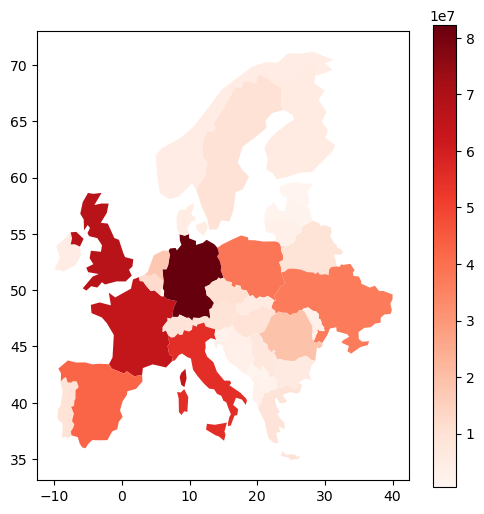

In [7]:
# Plot the population data on a map
f, ax = plt.subplots(1, 1, figsize=(6, 6))
gdf_europe_with_population.plot(column='total_population', 
                                ax=ax, 
                                cmap='Reds', 
                                markersize=1, 
                                legend=True)
plt.show()

Zonal statistics allow for the aggregation of raster data within specified vector zones, providing valuable insights into spatial data distributions. This example demonstrates the calculation of the total population per European country by aggregating the GHSL's grid-level population data. 

We note that one may expect the population levels to be integer numbers, while here we see floats - the reason behind this is that the GHSL data contains modeled population levels, which were not rounded to integers. 

We also note that when we start to compare the computed population levels of each country to official records, in some cases, we might see as high differences as about 10% to today's population, which may have several reasons. First, we are using projected data for 2030, which may include various factors. Second, the GHSL is a global data set, which means that it provides data from every corner of the globe, which usually comes at the cost of local accuracy. Third, our masking and the country-level boundaries may not match the latest official boundary lines perfectly.

&nbsp;

&nbsp;

### 10. Convert a Raster Grid into Vector Data

Converting raster data into vector data is a geospatial analytics exercise that allows for more flexibility when switching back and forth between raster and vector data. Raster data is composed of a grid of cells, each with one or more numeric values, while vector data represents features as points, lines, or polygons. 

In this section, we will convert the clipped European population raster grid into a vector format -  a `GeoDataFrame` of point geometries created in `Shapely`, where each point corresponds to a raster cell with a population value. The process involves reading the raster data using `Rasterio`, iterating over the raster cells, extracting their coordinates and values, and creating `Point` geometries for non-NaN and non-zero values. These points and their associated population values are then used to create a `GeoDataFrame` with a defined coordinate reference system (CRS). Finally, we visualize the resulting point data using `Matplotlib`.

In [8]:
# Import necessary libraries
import geopandas as gpd
import rasterio
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Path to your clipped raster file
clipped_raster_file = 'clipped_raster_europe.tif'

# Open the raster file and read the data
with rasterio.open(clipped_raster_file) as src:
    raster_data = src.read(1)
    transform = src.transform
    rows, cols = raster_data.shape

# Create lists to hold point geometries and cell values
points = []
values = []

# Loop through the raster data
for row in range(0, rows, 10):  # Adjust the step size as needed
    for col in range(0, cols, 10):  # Adjust the step size as needed
        value = raster_data[row, col]
        if value > 0:  # Only add non-NaN and non-zero values
            # Get the (x, y) coordinates for the cell
            x, y = rasterio.transform.xy(transform, row, col)
            points.append(Point(x, y))
            values.append(value)

64907


,population,geometry
0,2.718014,POINT (23.91292 71.00375)
1,9.466147,POINT (24.66292 71.00375)
2,0.971620,POINT (24.99625 71.00375)
3,40.819069,POINT (25.49625 70.92042)
4,1.112879,POINT (27.41292 70.92042)


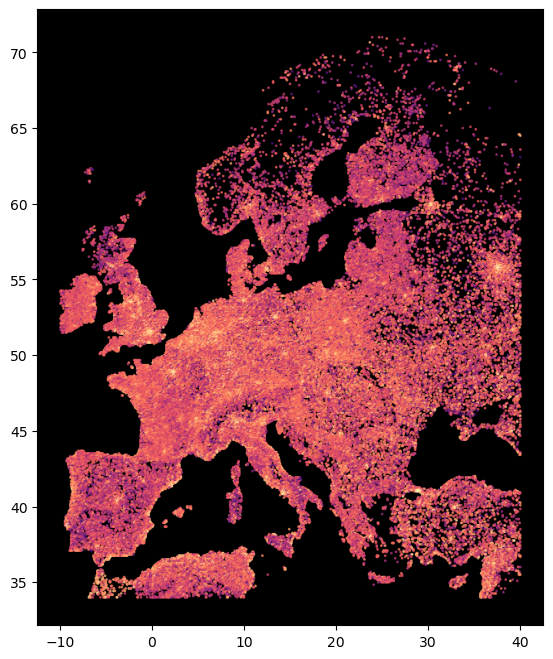

In [9]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'population': values, 'geometry': points})

# Use the original CRS of the raster data
gdf.crs = src.crs

# Print the size of the GeoDataFrame
print(len(gdf))

# Display the GeoDataFrame
display(gdf.head())

# Normalize the population values for better visualization
norm = LogNorm(vmin=gdf['population'].min(), vmax=gdf['population'].max())

# Plot the GeoDataFrame
f, ax = plt.subplots(1, 1, figsize=(8, 8))
gdf.plot(column='population', 
         ax=ax, 
         cmap='magma', 
         markersize=1, 
         alpha=0.7, 
         norm=norm)

ax.set_facecolor("black")
plt.show()

Converting raster grids into vector data supports more detailed and flexible geospatial analysis. In this example, we reviewed how to transform a population raster grid into a vector format consisting of point geometries located according to the corresponding grid cell's coordinates.

### 11. Reading Large Raster Files Efficiently

Reading large raster files efficiently is crucial for geospatial analysis,  when dealing with high-resolution datasets that can be dozens of gigabytes in size. Efficient data handling prevents excessive memory usage and speeds up processing times. Now we will learn about the library called [rioxarray](https://corteva.github.io/rioxarray/stable/), which provides handy tools to read and manipulate large raster files using chunking and parallel processing. 

We will read two large raster files containing global population data for the year 2030, provided by the Global Human Settlement Layer (GHSL) project. These files are at different spatial resolutions, 1000m and 100m pixel size, in Mollweide projection. We use the  `rioxarray.open_rasterio` method to parse these files, whereby setting the `chunks` parameter, we can control how the data is divided into smaller pieces for processing while using the `lock` parameter, we can manage access to the data in parallel computing environments. These optimizations enable handling large datasets without overwhelming system resources.

*NOTE*

THis will be treated in the Advanced Training.


After reading and printing the attributes of these two data files of 1000m and 100m resolution, we can observe that both files have a single band, and the 1000m resolution raster data has dimensions of (1, 18000, 36082) with a maximum population value of 452,635 and a mean of approximately 61.89, indicating coarser granularity suitable for large-scale analysis. In contrast, the 100m resolution raster data, with dimensions ten times larger than (1, 180000, 360820), shows a maximum population value of 111,627 and a significantly lower mean of around 0.62, reflecting finer detail and more precise population distribution, suitable for detailed, small-scale analysis.

### 12. Clipping Large Raster Files

Clipping raster files is a common geospatial operation used to focus on a specific region of interest, thereby reducing data size and improving processing efficiency. While we previously demonstrated clipping using `Rasterio`, we now introduce a new tool, [xarray](http://xarray.pydata.org/en/stable/), which offers advanced and efficient data handling capabilities for large datasets. Clipping with `xarray` leverages its integration with `rioxarray`, providing seamless workflows for large-scale geospatial data analysis. The `xarray` library, along with `rioxarray`, facilitates efficient raster data operations with the benefits of chunking and parallel processing. 

In this section, we will clip a large raster file to a defined bounding box using `xarray` and `rioxarray`. The process involves reading the raster data into an `xarray.DataArray` and then using the `rio.clip_box` method to specify the bounding box coordinates. We then compare the size of the original and clipped data arrays to observe the effect of clipping. Again, we used Europe as a target area, defining its bounding box in the Mollweide coordinate system.

*NOTE*

THis will be treated in the Advanced Training.


The original DataArray has dimensions of (1, 18000, 36082) while the clipped one is the size of (1, 3500, 3500), which illustrates the results of clipping the global data file to contain only Europe.

### 13. Visualizing Large Raster Files


Visualizing large raster files is essential for understanding and analyzing the geospatial data stored in that file, especially when dealing with high-resolution datasets that contain vast amounts of information. Traditional plotting methods can be inefficient for such large datasets, so tools like [datashader](https://datashader.org/getting_started/Introduction.html) and [colorcet](https://colorcet.holoviz.org/) are used for efficient and visually appealing data visualizations. `datashader` efficiently renders large datasets, while `colorcet` provides a wide range of [colormaps](https://colorcet.holoviz.org/user_guide/index.html) to enhance the visual representation of the data. 

In this section, we will first read the global GHSL data at 1000m resolution and clip it to cover Europe only. Then, we conduct additional data processing steps, such as ensuring all values are positive and are oriented in the correct direction. We then create a canvas with `datashader`, define the plot size and aspect ratio, rasterize the data, and apply a colormap from `colorcet` for visual enhancement. Finally, we use `datashader.transfer_functions` to display the raster image.

*NOTE*

THis will be treated in the Advanced Training.


### 14. Downsampling a Large Raster File



Downsampling is a technique used to reduce the resolution of raster data, making it more manageable for analysis and visualization. This technique is particularly useful when developing initial explorative analytics on a new, large-scale data set in preparation for the final computation conducted on the full database. The main idea behind this process involves aggregating the values of neighboring cells to create a lower-resolution raster, which retains essential information while significantly reducing data size. 

In this section, we will demonstrate how to downsample the 100m resolution GHSL population data file using `xarray`. After importing the necessary libraries, we use the usual raster data loader. Then, we define a `downsample_raster` function that takes a `data_array` and a `factor` as inputs and returns the downsampled raster by averaging the values of pixels within the specified factor. For this, we define different downsampling levels and apply the downsampling function to the original data array with these factor values to finish the downsampling. At each downsampling step, we also print the number of remaining grid cells to illustrate the efficiency of downsampling.

*NOTE*

THis will be treated in the Advanced Training.



This example shows how to downsample a raster dataset at various levels, with significant reductions in the number of cells as the downsampling factor increases: starting from the original size, a downsampling factor of 2 reduces the cell count to 16,236,900,000, while a factor of 100 reduces it further to 6,494,400 cells.

### Summary on Raster Data

In this notebook, we explored various techniques for managing and analyzing raster data using Python. We began by reading and writing raster files with Rasterio, then demonstrated clipping rasters to specific regions using GeoPandas. Reprojecting rasters was covered to facilitate coordinate system transformations, and we explored visualization methods using Rasterio and Matplotlib.

We enhanced raster visualization with histogram equalization and applied simple functions like normalization and reclassification. We computed zonal statistics to summarize raster data within vector zones and converted raster grids into vector data, allowing for more flexible analysis. We learned about efficient reading and manipulation of large raster files with Rioxarray and Xarray. Lastly, we highlighted the importance of downsampling large raster files to reduce data size while retaining essential information.

These techniques equip us with the skills to handle extensive raster datasets effectively, enabling sophisticated geospatial analyses and streamlined data processing workflows.

## Exercise

1. Repeat the cells by taking defining a smaller bounding box that is used to clip the Europe data.
2. If your computer has the capacity, perform steps/cells 1 to 4, and clip another continent - Africa, or Asia. Then execute all the remaining cells - 5 to 10 - on this new clipped dataset.